In [46]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import difPy
import random
import numpy as np
from scipy import ndimage
import math
from scipy.ndimage import uniform_filter1d
import os
import cv2
from skimage.morphology import extrema
from skimage.segmentation import watershed as skwater

%matplotlib widget

In [47]:
meta_data_file_path = "/Training/train.csv"
meta_data_testing_file_path = "/Testing/test.csv"
original_data_folder = "data_original"
pre_processed_data_folder = "pre_processed_data"
training_folder = "../data_original/Training/"
testing_folder = "../data_original/Testing"
output_folder = "../output/pre_analysis"
tex_folder = "/tex"
pdf_folder = "/pdf"

In [48]:
meta_data_df = pd.read_csv("../" + original_data_folder + meta_data_file_path)
meta_data_testing_df = pd.read_csv("../" + original_data_folder + meta_data_testing_file_path)

In [49]:
labels = list(meta_data_df["Label"].unique())
planes = list(meta_data_df["Plane"].unique())

In [50]:
# Set random seed for reproducibility
random.seed(10)

#### Show df for Training-Folder

In [51]:
meta_data_df

,Image ID,Label,Plane,Width,Height,Path
0,Tr-gl_0954,glioma,sagittal,512,512,../data_original/Training/glioma/Tr-gl_0954.jpg
1,Tr-gl_0959,glioma,sagittal,512,512,../data_original/Training/glioma/Tr-gl_0959.jpg
2,Tr-gl_1033,glioma,sagittal,512,512,../data_original/Training/glioma/Tr-gl_1033.jpg
3,Tr-gl_1096,glioma,sagittal,512,512,../data_original/Training/glioma/Tr-gl_1096.jpg
4,Tr-gl_1290,glioma,axial,512,512,../data_original/Training/glioma/Tr-gl_1290.jpg
...,...,...,...,...,...,...
5707,Tr-no_1294,notumor,axial,225,225,../data_original/Training/notumor/Tr-no_1294.jpg
5708,Tr-no_0970,notumor,axial,234,225,../data_original/Training/notumor/Tr-no_0970.jpg
5709,Tr-no_1371,notumor,axial,441,442,../data_original/Training/notumor/Tr-no_1371.jpg
5710,Tr-no_0233,notumor,axial,207,207,../data_original/Training/notumor/Tr-no_0233.jpg


### View multiple random samples

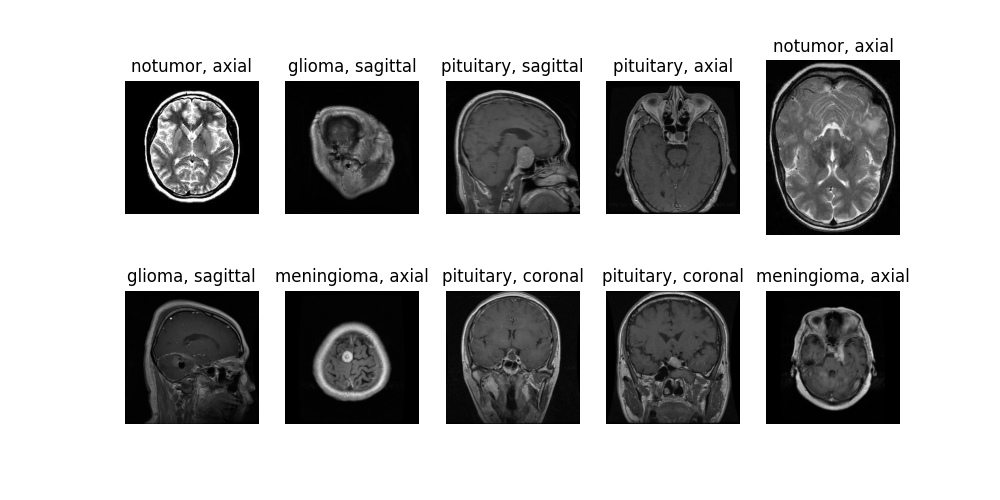

In [52]:
def view_mulitiple_samples(file_names_list, count=10, fig_size=(9, 4)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    random_samples = random.sample(file_names_list, count)   
    fig = plt.figure(figsize=fig_size)

    counter = 1
    for sample in random_samples:
        plt.subplot(rows, 5, counter)
        plt.title(sample.split("/")[-2] + ", " + meta_data_df[meta_data_df["Path"] == sample]["Plane"].item())
        plt.axis('off')
        plt.imshow(cv2.imread(sample))
        counter+=1
    return

view_mulitiple_samples(list(meta_data_df["Path"]), count=10, fig_size=(10, 5))

### Check for duplicates

##### Check with difPy

In [53]:
dif = difPy.build(training_folder)
search = difPy.search(dif)

difPy preparing files: [100%]
difPy searching files: [100%]


In [54]:
print("Amount of duplicates: ", len(search.result))

Amount of duplicates:  155


#### delete duplicates

In [55]:
def get_all_duplicate_file_paths(search_result):
    all_duplicate_file_paths = []
    for original_id in search_result:
        matches = search_result[original_id]["matches"]
        for match in matches:
            duplicate_file_path = matches[match]["location"]
            if duplicate_file_path not in all_duplicate_file_paths:
                all_duplicate_file_paths.append(matches[match]["location"])
    return all_duplicate_file_paths

In [56]:
all_duplicate_file_paths = get_all_duplicate_file_paths(search.result)

In [57]:
print("Amount of total duplicates to be deleted:", len(all_duplicate_file_paths))

Amount of total duplicates to be deleted: 207


### Update df with deleted images

In [58]:
drop_index = []
for path in all_duplicate_file_paths:
    drop_index.append(list(meta_data_df[meta_data_df['Path'] == path].index)[0])

dropped_duplicats_df = meta_data_df.drop(meta_data_df.index[drop_index])
dropped_duplicats_df

,Image ID,Label,Plane,Width,Height,Path
0,Tr-gl_0954,glioma,sagittal,512,512,../data_original/Training/glioma/Tr-gl_0954.jpg
1,Tr-gl_0959,glioma,sagittal,512,512,../data_original/Training/glioma/Tr-gl_0959.jpg
2,Tr-gl_1033,glioma,sagittal,512,512,../data_original/Training/glioma/Tr-gl_1033.jpg
3,Tr-gl_1096,glioma,sagittal,512,512,../data_original/Training/glioma/Tr-gl_1096.jpg
4,Tr-gl_1290,glioma,axial,512,512,../data_original/Training/glioma/Tr-gl_1290.jpg
...,...,...,...,...,...,...
5705,Tr-no_1177,notumor,axial,225,225,../data_original/Training/notumor/Tr-no_1177.jpg
5707,Tr-no_1294,notumor,axial,225,225,../data_original/Training/notumor/Tr-no_1294.jpg
5709,Tr-no_1371,notumor,axial,441,442,../data_original/Training/notumor/Tr-no_1371.jpg
5710,Tr-no_0233,notumor,axial,207,207,../data_original/Training/notumor/Tr-no_0233.jpg


### Images sizes

#### Show amount of images for Width==Height

In [59]:
dropped_duplicats_df[(dropped_duplicats_df["Height"] == dropped_duplicats_df["Width"]) & (dropped_duplicats_df["Plane"] == "axial")]

,Image ID,Label,Plane,Width,Height,Path
4,Tr-gl_1290,glioma,axial,512,512,../data_original/Training/glioma/Tr-gl_1290.jpg
5,Tr-gl_0042,glioma,axial,512,512,../data_original/Training/glioma/Tr-gl_0042.jpg
8,Tr-gl_0157,glioma,axial,512,512,../data_original/Training/glioma/Tr-gl_0157.jpg
9,Tr-gl_0543,glioma,axial,512,512,../data_original/Training/glioma/Tr-gl_0543.jpg
10,Tr-gl_0555,glioma,axial,512,512,../data_original/Training/glioma/Tr-gl_0555.jpg
...,...,...,...,...,...,...
5703,Tr-no_0575,notumor,axial,225,225,../data_original/Training/notumor/Tr-no_0575.jpg
5705,Tr-no_1177,notumor,axial,225,225,../data_original/Training/notumor/Tr-no_1177.jpg
5707,Tr-no_1294,notumor,axial,225,225,../data_original/Training/notumor/Tr-no_1294.jpg
5710,Tr-no_0233,notumor,axial,207,207,../data_original/Training/notumor/Tr-no_0233.jpg


In [60]:
height_width_df = pd.DataFrame(index=["total"])
for label in labels:
    height_width_df.loc["total", label] = len(dropped_duplicats_df[(dropped_duplicats_df["Height"] == dropped_duplicats_df["Width"]) & (dropped_duplicats_df["Label"] == label)])

height_width_df

,glioma,meningioma,pituitary,notumor
total,1321.0,1216.0,1438.0,444.0


### Drop all images with Height != Width for all tumor-types; keep ratio 0.9-1.1 for notumor

In [61]:
reduced_df = dropped_duplicats_df[((dropped_duplicats_df["Height"] <= dropped_duplicats_df["Width"] * 1.1) & (dropped_duplicats_df["Height"] >= dropped_duplicats_df["Width"] * 0.9) & (dropped_duplicats_df["Width"] <= dropped_duplicats_df["Height"] * 1.1) & (dropped_duplicats_df["Width"] >= dropped_duplicats_df["Height"] * 0.9) & (dropped_duplicats_df["Label"] == "notumor")) | ((dropped_duplicats_df["Height"] == dropped_duplicats_df["Width"]) & (dropped_duplicats_df["Label"] != "notumor"))]
reduced_df

,Image ID,Label,Plane,Width,Height,Path
0,Tr-gl_0954,glioma,sagittal,512,512,../data_original/Training/glioma/Tr-gl_0954.jpg
1,Tr-gl_0959,glioma,sagittal,512,512,../data_original/Training/glioma/Tr-gl_0959.jpg
2,Tr-gl_1033,glioma,sagittal,512,512,../data_original/Training/glioma/Tr-gl_1033.jpg
3,Tr-gl_1096,glioma,sagittal,512,512,../data_original/Training/glioma/Tr-gl_1096.jpg
4,Tr-gl_1290,glioma,axial,512,512,../data_original/Training/glioma/Tr-gl_1290.jpg
...,...,...,...,...,...,...
5705,Tr-no_1177,notumor,axial,225,225,../data_original/Training/notumor/Tr-no_1177.jpg
5707,Tr-no_1294,notumor,axial,225,225,../data_original/Training/notumor/Tr-no_1294.jpg
5709,Tr-no_1371,notumor,axial,441,442,../data_original/Training/notumor/Tr-no_1371.jpg
5710,Tr-no_0233,notumor,axial,207,207,../data_original/Training/notumor/Tr-no_0233.jpg


#### Data distribution after removing duplicates and width!=height

In [62]:
tumor_plane_count_df = pd.DataFrame()

for label in labels:
    tumor_plane_count_df.loc["total", "total"] = len(reduced_df)
    tumor_plane_count_df.loc[label, "total"] = len(reduced_df[(reduced_df["Label"] == label)])
    for plane in planes:
        tumor_plane_count_df.loc[label, plane] = len(reduced_df[(reduced_df["Plane"] == plane) & (reduced_df["Label"] == label)])
        tumor_plane_count_df.loc["total", plane] = len(reduced_df[(reduced_df["Plane"] == plane)])

tumor_plane_count_df.T

,total,glioma,meningioma,pituitary,notumor
total,4792.0,1321.0,1216.0,1438.0,817.0
sagittal,1383.0,354.0,457.0,512.0,60.0
axial,2020.0,482.0,357.0,424.0,757.0
coronal,1389.0,485.0,402.0,502.0,0.0


#### Remove bias that occurs due to fewer notumor files

In [63]:
def get_random_sample_of_indices():
    remaining_indices = []
    labels_without_notumor = labels.copy()
    labels_without_notumor.remove("notumor")
    for label in labels_without_notumor:
        remaining_indices.append(random.sample(list(reduced_df[reduced_df["Label"] == label].index), random.randint(700, 900)))

    remaining_indices.append(reduced_df[reduced_df["Label"] == "notumor"].index)

    return [item for sublist in remaining_indices for item in sublist]

In [64]:
equal_distribution_df = reduced_df.loc[get_random_sample_of_indices()]

In [65]:
equal_tumor_plane_count_df = pd.DataFrame()

for label in labels:
    equal_tumor_plane_count_df.loc["total", "total"] = len(equal_distribution_df)
    equal_tumor_plane_count_df.loc[label, "total"] = len(equal_distribution_df[(equal_distribution_df["Label"] == label)])
    for plane in planes:
        equal_tumor_plane_count_df.loc[label, plane] = len(equal_distribution_df[(equal_distribution_df["Plane"] == plane) & (equal_distribution_df["Label"] == label)])
        equal_tumor_plane_count_df.loc["total", plane] = len(equal_distribution_df[(equal_distribution_df["Plane"] == plane)])

equal_tumor_plane_count_df.T

,total,glioma,meningioma,pituitary,notumor
total,3207.0,867.0,802.0,721.0,817.0
sagittal,863.0,232.0,315.0,256.0,60.0
axial,1535.0,322.0,233.0,223.0,757.0
coronal,809.0,313.0,254.0,242.0,0.0


### Flip & rotate all images

In [66]:
new_dimension = (256, 256)

In [67]:
def random_rotation(img):
    degrees = [90, -90, 180, -180]
    degree = 0
    if random.choice([0, 0, 0, 1]) == 1:
        degree = random.choice(degrees)
    return ndimage.rotate(img, degree, reshape=False), str(degree)

In [68]:
def random_rotation_ten_degrees(img):
    probability = random.randrange(0, 100)
    if probability < 50:
        degree = random.randrange(-10, 10)
        return ndimage.rotate(img, degree, reshape=False), str(degree)
    return img, "0"

In [69]:
small_image = meta_data_df[(meta_data_df["Height"] == 192) & (meta_data_df["Width"] == 192)].iloc[5]
small_image_path = small_image["Path"]
width = small_image["Width"]
height = small_image["Height"]

plt.close()
img = cv2.imread(small_image_path, cv2.IMREAD_GRAYSCALE)
resized_img = cv2.resize(img, new_dimension)
rotated_img, degree = random_rotation(img)

0


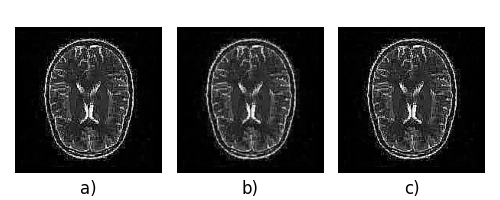

In [70]:
plt.close()
fig = plt.figure(figsize=(5, 2))
plt.subplot(1, 3, 1)
plt.title("a)", y=-0.2)
plt.axis('off')
plt.imshow(img, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("b)", y=-0.2)
plt.axis('off')
plt.imshow(resized_img, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("c)", y=-0.2)
plt.axis('off')
plt.imshow(rotated_img, cmap="gray")
print(degree)
plt.tight_layout()
plt.savefig(output_folder + "/pdf/rotation_resize_example.pdf")
plt.show()

### Histogram equalisation
#### Global histogram equalisation

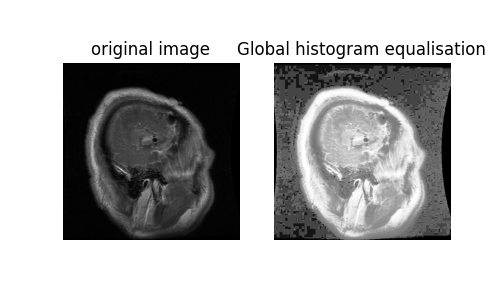

No such comm: 273d3c2510e4474faf716a0a893174e2
No such comm: 273d3c2510e4474faf716a0a893174e2
No such comm: 273d3c2510e4474faf716a0a893174e2
No such comm: 273d3c2510e4474faf716a0a893174e2
No such comm: 273d3c2510e4474faf716a0a893174e2
No such comm: 273d3c2510e4474faf716a0a893174e2


In [ ]:
plt.close()
img = cv2.imread(meta_data_df.iloc[0]["Path"], cv2.IMREAD_GRAYSCALE)
equ = cv2.equalizeHist(img)

fig = plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
plt.title("original image")
plt.axis('off')
plt.imshow(img, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Global histogram equalisation")
plt.axis('off')
plt.imshow(equ, cmap="gray")
plt.show()

#### Contrast Limited Adaptive Histogram Equalization (CLAHE)

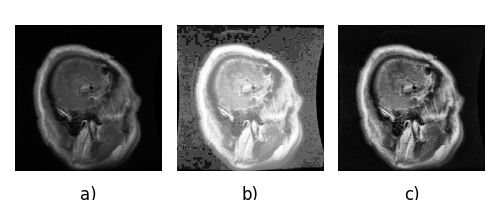

In [72]:
plt.close()
img = cv2.imread(meta_data_df.iloc[0]["Path"], cv2.IMREAD_GRAYSCALE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)

fig = plt.figure(figsize=(5, 2))
plt.subplot(1, 3, 1)
plt.title("a)", y=-0.25)
plt.axis('off')
plt.imshow(img, cmap="gray")
plt.imsave(output_folder + pdf_folder + "/histogram_equalisation_original.pdf", img, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("b)", y=-0.25)
plt.axis('off')
plt.imshow(equ, cmap="gray")
plt.imsave(output_folder + pdf_folder + "/histogram_equalisation_equ.pdf", equ, cmap="gray")


plt.subplot(1, 3, 3)
plt.title("c)", y=-0.25)
plt.axis('off')
plt.imshow(cl1, cmap="gray")
plt.imsave(output_folder + pdf_folder + "/histogram_equalisation_clahe.pdf", cl1, cmap="gray")
plt.tight_layout()
plt.show()

### Histogram matching; reference: avg of 100 sample images for each label

In [73]:
def cumululative(list_of_values):
    sum_values = sum(list_of_values)
    cumululative_list = []  
    temp = 0
    for i in list_of_values:
        temp += i
        cumululative_list.append(temp/sum_values)
    return cumululative_list

In [74]:
def get_average_eq_histogram(paths, df):
    average_histogram = np.zeros(256)

    for image_path in paths:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Convert to grayscale
        histogram, _ = np.histogram(img, bins=256, range=(0, 255))
        for i, val in enumerate(histogram):
            average_histogram[i] += val/len(df)

    return average_histogram, cumululative(average_histogram)

In [75]:
def get_average_eq_histogram_cdf_by_label(df, label):
    random_sample = random.sample(list(df[df["Label"] == label]["Path"]), 100)
    sample_df = df[df["Path"].isin(random_sample)]
    return get_average_eq_histogram(random_sample, sample_df)

In [76]:
def get_average_eq_historgram_total(training_df, testing_df):
    combined_df = pd.concat([training_df, testing_df], axis=0)
    random_sample = random.sample(list(combined_df["Path"]), 100)
    return get_average_eq_histogram(random_sample, combined_df)

In [77]:
def get_matching_index(value, cum_list):
    for i, element in enumerate(cum_list):
        if value <= element:
            top_diff = element - value
            bot_diff = math.inf
            if i > 0:
                bot_diff = value - cum_list[i-1]
            if top_diff < bot_diff:
                return i
            else:
                return i-1 
    return len(cum_list)-1

In [78]:
def get_map_list(reference_dist, current_dist):
    to_ref_map = np.zeros_like(reference_dist)
    for i, value in enumerate(current_dist):
        index = get_matching_index(value, reference_dist)
        to_ref_map[i] = index

    return to_ref_map

In [79]:
def generate_histogram_cdf(img):
    gr_hist = np.zeros([256])
    for x_pixel in range(img.shape[0]):
        for y_pixel in range(img.shape[1]):
            pixel_value = int(img[x_pixel, y_pixel])
            gr_hist[pixel_value] += 1
    return gr_hist, cumululative(gr_hist)

In [80]:
def get_matched_image_from_histogram(img, map_list):
    return [[map_list[j] for j in i] for i in img]

In [81]:
orig_img = cv2.imread(meta_data_df.iloc[1]["Path"], cv2.IMREAD_GRAYSCALE)
eq_img = clahe.apply(orig_img)
eq_hist, eq_cdf = generate_histogram_cdf(eq_img)
_, reference_cdf = get_average_eq_histogram_cdf_by_label(meta_data_df, "glioma")
map_list = get_map_list(reference_cdf, eq_cdf)

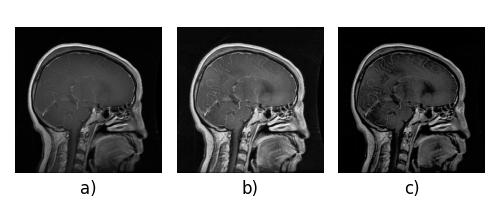

In [82]:
fig = plt.figure(figsize=(5, 2))
plt.subplot(1, 3, 1)
plt.title("a)", y=-0.2)
plt.axis('off')
plt.imshow(orig_img, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("b)", y=-0.2)
plt.axis('off')
plt.imshow(eq_img, cmap="gray")

matched_img = get_matched_image_from_histogram(eq_img, map_list)
plt.subplot(1, 3, 3)
plt.title("c)", y=-0.2)
plt.axis('off')
plt.imshow(matched_img, cmap="gray")
plt.tight_layout()
plt.show()

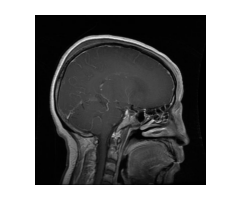

In [83]:
plt.clf()
fig = plt.figure(figsize=(2.4, 2))
plt.imshow(orig_img, cmap="gray")
plt.axis('off')
plt.tight_layout()
plt.savefig(output_folder + pdf_folder + "/histogram_matching_original.pdf")
plt.show()

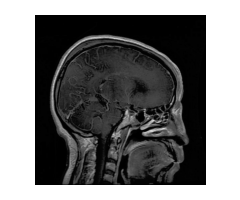

In [84]:
plt.clf()
fig = plt.figure(figsize=(2.4, 2))
plt.imshow(matched_img, cmap="gray")
plt.axis('off')
plt.tight_layout()
plt.savefig(output_folder + pdf_folder + "/histogram_matching_matched.pdf")
plt.show()

### Save new rotated, resized and equalised images
#### Training dataset

In [85]:
resized_folder = "normalized_label_256_256_data"
new_dimension = (256, 256)

### Preprocessing Testing Data

In [86]:
dif_testing = difPy.build(testing_folder)
search_testing = difPy.search(dif_testing)

difPy preparing files: [100%]
difPy searching files: [100%]


In [87]:
print("Amount of duplicates: ", len(search_testing.result))

Amount of duplicates:  21


No such comm: c949a9bfd580491f841b1789b1317fb9


Amount of duplicates:  21


No such comm: 125eee61fc594835b92280f76ea77387


Amount of duplicates:  21


No such comm: 7e07e9fd8c3849198fd1e281c27cf3f8


Amount of duplicates:  21


In [88]:
all_duplicate_file_paths_testing = get_all_duplicate_file_paths(search_testing.result)

In [89]:
print("Amount of total duplicates to be deleted in testing:", len(all_duplicate_file_paths_testing))

Amount of total duplicates to be deleted in testing: 30


In [90]:
drop_index_testing = []
for path in all_duplicate_file_paths_testing:
    drop_index_testing.append(list(meta_data_testing_df[meta_data_testing_df['Path'] == path].index)[0])

dropped_duplicats_testing_df = meta_data_testing_df.drop(meta_data_testing_df.index[drop_index_testing])

In [91]:
reduced_testing_df = dropped_duplicats_testing_df[((dropped_duplicats_testing_df["Height"] <= dropped_duplicats_testing_df["Width"] * 1.1) & (dropped_duplicats_testing_df["Height"] >= dropped_duplicats_testing_df["Width"] * 0.9) & (dropped_duplicats_testing_df["Width"] <= dropped_duplicats_testing_df["Height"] * 1.1) & (dropped_duplicats_testing_df["Width"] >= dropped_duplicats_testing_df["Height"] * 0.9) & (dropped_duplicats_testing_df["Label"] == "notumor")) | ((dropped_duplicats_testing_df["Height"] == dropped_duplicats_testing_df["Width"]) & (dropped_duplicats_testing_df["Label"] != "notumor"))]

In [92]:
tumor_plane_count_testing_df = pd.DataFrame()

for label in labels:
    tumor_plane_count_testing_df.loc["total", "total"] = len(reduced_testing_df)
    tumor_plane_count_testing_df.loc[label, "total"] = len(reduced_testing_df[(reduced_testing_df["Label"] == label)])
    
tumor_plane_count_testing_df.T

,total,glioma,meningioma,pituitary,notumor
total,1024.0,299.0,207.0,300.0,218.0


### Save new rotated, resized and equalised images
#### Training dataset

In [100]:
resized_folder = "256_256_less_rotation_data"
new_dimension = (256, 256)

In [101]:
avg_histogram_cdf = get_average_eq_historgram_total(equal_distribution_df, reduced_testing_df)[1]

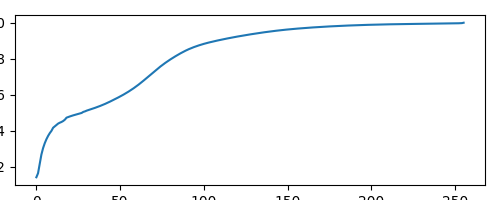

In [102]:
plt.close()
plt.plot(avg_histogram_cdf)
plt.show()

In [103]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) # required for equalisation with clahe

#for plane in planes:
for label in labels:
        new_folder = "../" + resized_folder + "/Training/" + label
        print(new_folder)
        if not os.path.exists(new_folder):
            os.makedirs(new_folder)
        #print(plane, label)
        #label_df = dropped_duplicats_df[(dropped_duplicats_df["Height"] == dropped_duplicats_df["Width"]) & (dropped_duplicats_df["Plane"] == "axial")]
        #label_df = equal_distribution_df[(equal_distribution_df["Label"] == label) & (equal_distribution_df["Plane"] == "axial")]
        label_df = equal_distribution_df[(equal_distribution_df["Label"] == label)]
        for i, row in label_df.iterrows():
            file_path = row["Path"]
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            rotated, _ = random_rotation_ten_degrees(img) # Rotate randomly
            eq_img = clahe.apply(rotated) # Apply histogram equalisation
        
            _, eq_cdf = generate_histogram_cdf(eq_img)
            map_list = get_map_list(avg_histogram_cdf, eq_cdf)
            matched_img = get_matched_image_from_histogram(eq_img, map_list) # match histogram
        
            resized = cv2.resize(eq_img, new_dimension) # Resize image
            new_file_path = file_path.replace(original_data_folder, resized_folder)
            #file_name = file_path.split("/")[3] + "/" + file_path.split("/")[4]
            #new_file_path = new_file_path.replace(file_name,  + "/" + file_name)

            cv2.imwrite(new_file_path, resized) # save image

../256_256_less_rotation_data/Training/glioma
../256_256_less_rotation_data/Training/meningioma
../256_256_less_rotation_data/Training/pituitary
../256_256_less_rotation_data/Training/notumor


##### update metadata and save to Training folder

In [104]:
resized_training_data_df = equal_distribution_df.copy()
for i, row in resized_training_data_df[resized_training_data_df["Plane"] == "axial"].iterrows():
    resized_training_data_df.loc[i, "Width"] = new_dimension[0]
    resized_training_data_df.loc[i, "Height"] = new_dimension[1]
    new_file_path = row["Path"].replace(original_data_folder, pre_processed_data_folder)
    #file_name = file_path.split("/")[3] + "/" + file_path.split("/")[4]
    #new_file_path = new_file_path.replace(file_name, plane + "/" + file_name)
    resized_training_data_df.loc[i, "Path"] = new_file_path

resized_training_data_df.to_csv("../" + resized_folder + meta_data_file_path)

#### Testing dataset

In [105]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) # required for equalisation with clahe

for i, row in reduced_testing_df.iterrows():
    new_folder = "../" + resized_folder + "/Testing/" + row["Label"]
    print(new_folder)
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)

    file_path = row["Path"]
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    rotated, _ = random_rotation_ten_degrees(img) # Rotate randomly
    
    eq_img = clahe.apply(rotated) # Apply histogram equalisation
    
    _, eq_cdf = generate_histogram_cdf(eq_img)
    map_list = get_map_list(avg_histogram_cdf, eq_cdf)
    matched_img = get_matched_image_from_histogram(eq_img, map_list) # match histogram
    
    resized = cv2.resize(eq_img, new_dimension) # Resize image
    new_file_path = file_path.replace(original_data_folder, resized_folder)
    #file_name = file_path.split("/")[3] + "/" + file_path.split("/")[4]
    #new_file_path = new_file_path.replace(file_name, plane + "/" + file_name)
    print(new_file_path)
    cv2.imwrite(new_file_path, resized) # save image

../256_256_less_rotation_data/Testing/glioma
../256_256_less_rotation_data/Testing/glioma/Te-glTr_0000.jpg
../256_256_less_rotation_data/Testing/glioma
../256_256_less_rotation_data/Testing/glioma/Te-glTr_0001.jpg
../256_256_less_rotation_data/Testing/glioma
../256_256_less_rotation_data/Testing/glioma/Te-glTr_0002.jpg
../256_256_less_rotation_data/Testing/glioma
../256_256_less_rotation_data/Testing/glioma/Te-glTr_0003.jpg
../256_256_less_rotation_data/Testing/glioma
../256_256_less_rotation_data/Testing/glioma/Te-glTr_0004.jpg
../256_256_less_rotation_data/Testing/glioma
../256_256_less_rotation_data/Testing/glioma/Te-glTr_0005.jpg
../256_256_less_rotation_data/Testing/glioma
../256_256_less_rotation_data/Testing/glioma/Te-glTr_0006.jpg
../256_256_less_rotation_data/Testing/glioma
../256_256_less_rotation_data/Testing/glioma/Te-glTr_0007.jpg
../256_256_less_rotation_data/Testing/glioma
../256_256_less_rotation_data/Testing/glioma/Te-glTr_0008.jpg
../256_256_less_rotation_data/Testing

### update metadata and save to Testing folder

In [106]:
reduced_testing_df_copy = reduced_testing_df.copy()
for i, row in reduced_testing_df_copy.iterrows():
    reduced_testing_df_copy.loc[i, "Width"] = new_dimension[0]
    reduced_testing_df_copy.loc[i, "Height"] = new_dimension[1]
    new_file_path = row["Path"].replace(original_data_folder, resized_folder)
    reduced_testing_df_copy.loc[i, "Path"] = new_file_path

reduced_testing_df_copy.to_csv("../" + resized_folder + meta_data_testing_file_path)
reduced_testing_df_copy

,Image ID,Label,Width,Height,Path
0,Te-glTr_0000,glioma,256,256,../256_256_less_rotation_data/Testing/glioma/T...
1,Te-glTr_0001,glioma,256,256,../256_256_less_rotation_data/Testing/glioma/T...
2,Te-glTr_0002,glioma,256,256,../256_256_less_rotation_data/Testing/glioma/T...
3,Te-glTr_0003,glioma,256,256,../256_256_less_rotation_data/Testing/glioma/T...
4,Te-glTr_0004,glioma,256,256,../256_256_less_rotation_data/Testing/glioma/T...
...,...,...,...,...,...
1306,Te-pi_0295,pituitary,256,256,../256_256_less_rotation_data/Testing/pituitar...
1307,Te-pi_0296,pituitary,256,256,../256_256_less_rotation_data/Testing/pituitar...
1308,Te-pi_0297,pituitary,256,256,../256_256_less_rotation_data/Testing/pituitar...
1309,Te-pi_0298,pituitary,256,256,../256_256_less_rotation_data/Testing/pituitar...
